Initial test of LSTM range prediction, based off: https://machinelearningmastery.com/how-to-develop-lstm-models-for-time-series-forecasting/ 

### Version History:
- 1.0.0 - building off of vapor fraction v.1.0.3 with a different dataset.
- 1.1.0 - using pre-trained models to predict. saving predicted vectors to text.

In [1]:
import os
import pandas
import matplotlib.pyplot as plt
import numpy
from numpy import array
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Flatten
from keras.models import load_model
from keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

Using TensorFlow backend.


In [73]:
def load_col(excelfile, col, process):
    dataset = pandas.read_excel(excelfile, sep='\t',
                               header=None,usecols=[col])
    if process==True:
        dataset = dataset.values[2:]
        dataset = dataset.astype('float32')
        scaler = MinMaxScaler(feature_range=(0,1))
        dataset = scaler.fit_transform(dataset)
        return dataset, scaler
    else:
        dataset = dataset.values[2:]
        dataset = dataset.astype('float32')
        return dataset

In [4]:
def split_sequence(sequence, n_steps_in, n_steps_out):
    X, y = list(), list()
    for i in range(len(sequence)):
        # Finding the end of the pattern
        end_ix = i + n_steps_in
        out_end_ix = end_ix + n_steps_out
        
        # Checking if we are beyond the sequence
        if out_end_ix > len(sequence):
            break
            
        # Gather input and output parts of pattern
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix: out_end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return array(X), array(y)

In [5]:
def load_model_results(dataset, n_steps_in, n_steps_out, model_file, plot):
    model = load_model(model_file)
    
    X_dataset, y_dataset = split_sequence(dataset, n_steps_in, n_steps_out)
    y_dataset = y_dataset.reshape((y_dataset.shape[0], y_dataset.shape[1]))  
    
    y_dataset_hat = model.predict(X_dataset)
    
    y_dataset_hat_1 = []
    for i in range(len(dataset) - n_steps_in - n_steps_out + 1):
        y_dataset_hat_1.append(y_dataset_hat[i][0])
        
    cut = n_steps_in-1
    dataset_cut = dataset[cut:-n_steps_out]
    
    if plot==True:
        plt.figure(figsize=(20,7))
        plt.rcParams["font.family"] = "Arial"
        plt.rcParams.update({'font.size': 22})
        plt.rcParams['axes.xmargin'] = 0
        plt.plot(dataset_cut, label='Original', color='blue');
        plt.plot(y_dataset_hat_1, label='Prediction', color='red', linestyle='--');
        plt.legend();
        plot_title = "Kingston Mass Flux Prediction, " + str(n_steps_in) + " In, " + str(n_steps_out) + " Out"
        plt.title(plot_title)
        plt.xlabel('Timestep',fontsize='24');
        plt.ylabel('Mass Flux',fontsize='24');
        plot_name = "mass_flux_prediction_overlay_" + str(n_steps_in) + "in_" + str(n_steps_out) + "out_edited.png"
        #plt.savefig(plot_name)
    elif plot==False:
        pass
    
    error = math.sqrt(mean_squared_error(y_dataset_hat_1, dataset_cut))
    print("{:.2f}".format(error*100) + "%")
    
    return error

In [6]:
def save_original_preds_text(original, preds, start_idx, outputfilename):

    input_vector_length = numpy.shape(original)[1]
    output_vector_length = numpy.shape(preds)[1]
    
    output_file = open(outputfilename, "w")

    print("Opened txt file")

    header = "original " + str(start_idx) + " to " + str(start_idx+input_vector_length) + "\n"
    output_file.write(header)
    for i in range(input_vector_length):
        entry = str(original[start_idx][i]) + "\n"
        output_file.write(entry)
    
    output_file.write("\n")
    
    header = "original " + str(start_idx+input_vector_length+1) + " to " + str(start_idx+input_vector_length+output_vector_length+1) + "\n"
    output_file.write(header)
    for i in range(output_vector_length):
        entry = str(original[start_idx+input_vector_length+1][i]) + "\n"
        output_file.write(entry)
        
    output_file.write("\n")
    
    header = "predicted " + str(start_idx+input_vector_length+1) + " to " + str(start_idx+input_vector_length+output_vector_length+1) + "\n"
    output_file.write(header)
    for i in range(output_vector_length):
        entry = str(preds[start_idx+input_vector_length+1][i]) + "\n"
        output_file.write(entry)

    print("Closed txt file")

In [ ]:
def save_original_preds_text_short(original, preds, start_idx, outputfilename):

    check_original = []
    check_pred = []
    
    input_vector_length = numpy.shape(original)[1]
    output_vector_length = numpy.shape(preds)[1]
    
    output_file = open(outputfilename, "w")

    print("Opened txt file")
    
    for i in range(output_vector_length):
        check_original.append(original[start_idx+i][0])
        
    for i in range(output_vector_length):
        check_pred.append(preds[start_idx-input_vector_length][i])
        entry = str(preds[start_idx-100][i]) + "\n"
        output_file.write(entry)

    print("Closed txt file")
    
    return check_original, check_pred

In [9]:
pressure_array, pressure_scaler = load_col('2018_Kingston et al._IJMF Part 2_Figure 5 Data Set.xlsx', 1, True)
pressure_array.shape

(30000, 1)

In [78]:
pressure_absolute = load_col('2018_Kingston et al._IJMF Part 2_Figure 5 Data Set.xlsx', 1, False)
pressure_absolute.shape

(30000, 1)

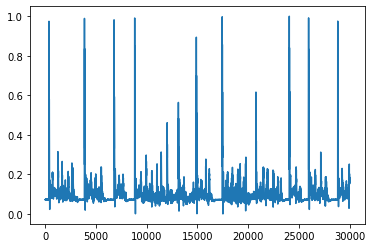

In [12]:
plt.plot(pressure_array)
plt.show()

Function to split dataset into vectors.

Beginning the preparation for LSTM.

In [13]:
# Fix random seed for reproducibility
numpy.random.seed(7)

print(pressure_array.shape)
# Splitting temperature data into vectors of size 100 and 50
n_steps_in, n_steps_out = 1000, 500
X_dataset, y_dataset = split_sequence(pressure_array, n_steps_in, n_steps_out)
print(X_dataset.shape, y_dataset.shape)

(30000, 1)
(28501, 1000, 1) (28501, 500, 1)


In [79]:
n_steps_in, n_steps_out = 1000, 500
X_dataset_absolute, y_dataset_absolute = split_sequence(pressure_absolute, n_steps_in, n_steps_out)
print(X_dataset_absolute.shape, y_dataset_absolute.shape)

(28501, 1000, 1) (28501, 500, 1)


In [15]:
extensions = [".h5"]
L = [f for f in os.listdir() if os.path.splitext(f)[1] in extensions]

In [16]:
print(L)

['kingston_mass1250fps.h5', 'kingston_mass2500fps_2000in.h5', 'kingston_mass2500fps_4000in.h5', 'kingston_mass625fps.h5', 'kingston_mass_testmodel_100in_50out.h5', 'kingston_press1250fps.h5', 'kingston_press2500fps_2000in.h5', 'kingston_press2500fps_4000in.h5', 'kingston_press625fps.h5', 'kingston_temp_testmodel_100in_50out.h5', 'lstm_temperature_model.h5']


In [105]:
print(L[7])

kingston_press2500fps_4000in.h5


In [18]:
model_list = []
for model_name in L:
    model = load_model(model_name)
    model_list.append(model)

In [14]:
model = load_model('kingston_mass_testmodel_100in_50out.h5')

In [20]:
print(X_dataset.shape)

(28501, 1000, 1)


In [21]:
model = model_list[8]
print(model)

In [25]:
y_dataset_reshape = y_dataset.reshape((y_dataset.shape[0], y_dataset.shape[1]))  
y_dataset_hat = model.predict(X_dataset, verbose=1)

28501/28501 [==============================] - 176s 6ms/step


In [136]:
# Un-scaling the data
y_dataset_hat_absolute = numpy.asarray(y_dataset_hat)
y_dataset_hat_absolute = pressure_scaler.inverse_transform(y_dataset_hat_absolute)
#pressure_absolute = pressure_scaler.inverse_transform(pressure_array)

C:\Users\cheo\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\_data.py:437: RuntimeWarning: overflow encountered in true_divide
  X /= self.scale_


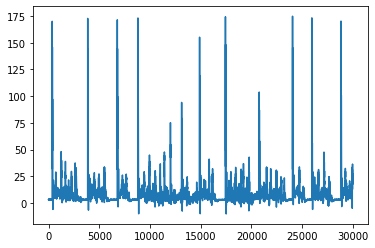

In [137]:
plt.plot(pressure_absolute)
plt.show()

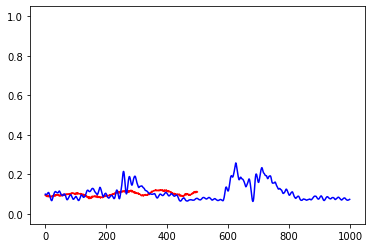

In [138]:
a=1000
plt.plot(y_dataset_hat[a], color='red')
plt.plot(X_dataset[a+1000], color='blue')
plt.plot(0)
plt.plot(1)
#plt.savefig("scaled.png")

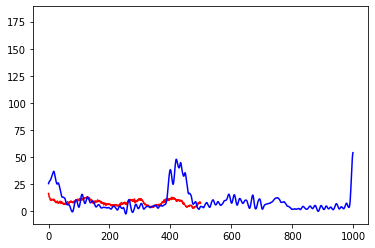

In [139]:
idx = 10000
input_vector_length = 1000
output_vector_length = 500
plt.plot(y_dataset_hat_absolute[idx], color='red')
plt.plot(X_dataset_absolute[idx+input_vector_length], color='blue')
plt.plot(0)
plt.plot(180)
#plt.savefig("unscaled.png")

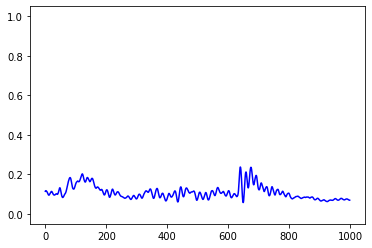

In [112]:
a=3850
plt.plot(y_dataset_hat[a], color='red')
plt.plot(X_dataset[a+1000], color='blue')
plt.plot(0)
plt.plot(1)
#plt.savefig("scaled.png")

In [124]:
pressure_4000_2000_model = load_model(L[7])

In [125]:
n_steps_in, n_steps_out = 4000,2000
X_dataset_4000, y_dataset_4000 = split_sequence(pressure_array, n_steps_in, n_steps_out)
print(X_dataset_4000.shape, y_dataset_2000.shape)

(24001, 4000, 1) (24001, 2000, 1)


In [126]:
y_dataset_4000_reshape = y_dataset_4000.reshape((y_dataset_4000.shape[0], y_dataset_4000.shape[1]))  
y_dataset_hat_4000 = pressure_4000_2000_model.predict(X_dataset_4000, verbose=1)

24001/24001 [==============================] - 549s 23ms/step


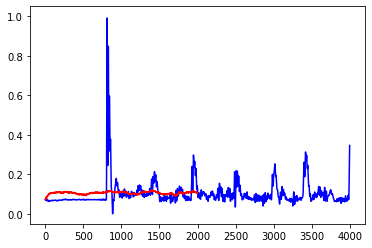

In [144]:
a=4000
plt.plot(X_dataset_4000[a+4000], color='blue')
plt.plot(y_dataset_hat_4000[a], color='red')
plt.plot(0)
plt.plot(1)
plt.savefig("scaled_4000.png")

In [162]:
def save_original_preds_text_short(original, preds, start_idx, outputfilename):

    check_original = []
    check_pred = []
    
    input_vector_length = numpy.shape(original)[1]
    output_vector_length = numpy.shape(preds)[1]
    print(input_vector_length)
    
    output_file = open(outputfilename, "w")

    print("Opened txt file")
    
    for i in range(output_vector_length):
        check_original.append(original[start_idx+i][0])
        
    for i in range(output_vector_length):
        check_pred.append(preds[start_idx-input_vector_length][i])
        entry = str(preds[start_idx-input_vector_length][i]) + "\n"
        output_file.write(entry)

    print("Closed txt file")
    
    return check_original, check_pred

In [ ]:
check_original_scaled, check_pred_scaled = save_original_preds_text_short(pressure_array, y_dataset_hat_4000

In [145]:
# Un-scaling the data
y_dataset_hat_4000_absolute = numpy.asarray(y_dataset_hat_4000)
y_dataset_hat_4000_absolute = pressure_scaler.inverse_transform(y_dataset_hat_4000_absolute)
#pressure_absolute = pressure_scaler.inverse_transform(pressure_array)

In [165]:
n_steps_in, n_steps_out = 4000,2000
X_dataset_4000_absolute, y_dataset_4000_absolute = split_sequence(pressure_absolute, n_steps_in, n_steps_out)
print(X_dataset_4000_absolute.shape, y_dataset_4000_absolute.shape)

(24001, 4000, 1) (24001, 2000, 1)


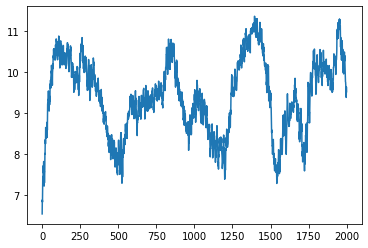

In [171]:
plt.plot(y_dataset_hat_4000_absolute[6792])

In [166]:
check_original_unscaled, check_pred_unscaled = save_original_preds_text_short(X_dataset_4000_absolute, y_dataset_hat_4000_absolute,
                                                                              6792,"pressure_prediction_P2793to6792.txt")

4000
Opened txt file
Closed txt file


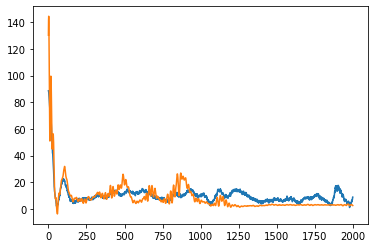

In [169]:
plt.plot(check_pred_unscaled)
plt.plot(check_original_unscaled)

In [172]:
check_original_unscaled, check_pred_unscaled = save_original_preds_text_short(X_dataset_4000_absolute, y_dataset_hat_4000_absolute,
                                                                              6764,"pressure_prediction_P2765to6764.txt")

4000
Opened txt file
Closed txt file


In [173]:
check_original_unscaled, check_pred_unscaled = save_original_preds_text_short(X_dataset_4000_absolute, y_dataset_hat_4000_absolute,
                                                                              6774,"pressure_prediction_P2775to6774.txt")

4000
Opened txt file
Closed txt file
